**Installing Required Libraries**

In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
!pip install pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

  Using cached pandas-1.3.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached numpy-1.21.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached seaborn-0.9.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached matplotlib-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached scikit-learn-0.20.1.tar.gz (9.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached setuptools_scm-8.1.0-py3-none-any.whl.metadata (6.6 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
 

In [ ]:
!pip install snapml

**Importing Required Libraries**

In [ ]:
from __future__ import print_function
from tqdm import tqdm

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys

sns.set_context('notebook')
sns.set_style('white')

**Defining Helper Functions**

In [ ]:
def memory_optimize(df):

    """
    optimize data types to reduce memory usage

    """
    for col in df.columns:
        if df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()

            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)

        elif df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()

            if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                df[col] = df[col].astype(np.int8)
            elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                df[col] = df[col].astype(np.int16)
            elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                df[col] = df[col].astype(np.int32)

    return df

**Introduction**

The dataset used in this exercise session is publicly available here (all rights reserved by Taxi & Limousine Commission(TLC), City of New York). The TLC Yellow Taxi Trip Records of June, 2019 are used in this project. The prediction of the tip amount can be modeled as a regression problem. To train the model we are using a part of the input dataset and the remaining data can be used to assess the quality of the trained model.

In [ ]:
!pip install skillsnetwork

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import skillsnetwork

await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0AXIEN/data/yellow_tripdata_2019-06_1M.tgz", overwrite = True)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to '.'


**Dataset Analysis**

*Reading input*

In [ ]:
import pandas as pd

In [ ]:
raw_data = pd.read_csv('yellow_tripdata_2019-06_1M.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

There are 1000000 observations in the dataset.
There are 19 variables in the dataset.


*display head rows*

In [ ]:
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-06-01 0:55,2019-06-01 0:56,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
1,1,2019-06-01 0:06,2019-06-01 0:06,1,0.0,1,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5,NaN
2,1,2019-06-01 0:17,2019-06-01 0:36,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0,NaN
3,1,2019-06-01 0:59,2019-06-01 0:59,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0,NaN
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,NaN


In [ ]:
#Some trips report 0 tip. It is assumed that these tips were paid in cash. For this study we drop all these rows:
raw_data = raw_data[raw_data['tip_amount'] > 0]

In [ ]:
#We also remove some outliers, namely those where the tip was larger than the fare cost:
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

In [ ]:
#We remove trips with very large fare cost, i.e.: greater than $200.
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

In [ ]:
#We drop variable that contains the target variable, namely the `total_amount`:
data = raw_data.drop(['total_amount'], axis=1)

In [ ]:
# Import necessary libraries (if needed, replace with your actual imports)
import pandas as pd

# Assuming your raw data is in a CSV file named 'your_data.csv'
# Load your raw data into a pandas DataFrame
raw_data = pd.read_csv('yellow_tripdata_2019-06_1M.csv') # Replace 'your_data.csv' with your actual file name

# Some trips report 0 tip. It is assumed that these tips were paid in cash.
# For this study we drop all these rows:
raw_data = raw_data[raw_data['tip_amount'] > 0]

# We also remove some outliers, namely those where the tip was larger than the fare cost:
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# We remove trips with very large fare cost, i.e.: greater than $200.
raw_data = raw_data[((raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200))]

# We drop variable that contains the target variable, namely the `total_amount`:
data = raw_data.drop(['total_amount'], axis=1)

In [ ]:
#We are dealing with a large dataset, thus we need to make sure we do not run out of memory. We can release the memory occupied by `raw_data` as we do not need it anymore.
import gc
del raw_data
gc.collect()

0

In [ ]:
print("There are " + str(len(data)) + " observations in the dataset.")
print("There are " + str(len(data.columns)) + " variables in the dataset.")

There are 682522 observations in the dataset.
There are 18 variables in the dataset.


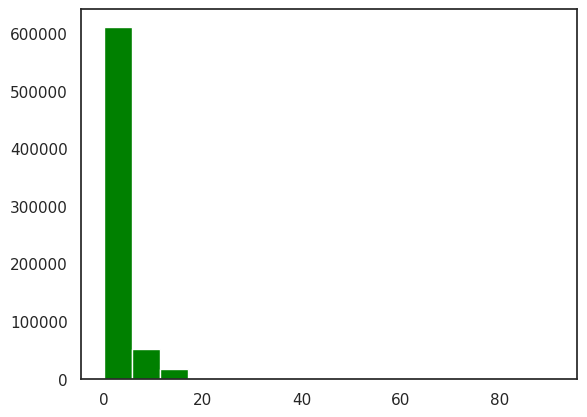

In [ ]:
plt.hist(data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

In [ ]:
print("Minimum amount value is ", np.min(data.tip_amount.values))
print("Maximum amount value is ", np.max(data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(data.tip_amount.values, 90))

Minimum amount value is  0.01
Maximum amount value is  91.0
90% of the trips have a tip amount less or equal than  5.88


In [ ]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,2.5,NaN
5,1,2019-06-01 0:28,2019-06-01 0:39,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,2.5,NaN
7,1,2019-06-01 0:54,2019-06-01 1:02,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.0,0.3,2.5,NaN
9,1,2019-06-01 0:29,2019-06-01 1:03,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.0,0.3,2.5,NaN
10,2,2019-06-01 0:01,2019-06-01 0:16,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.0,0.3,2.5,NaN


***Data preprocessing***

In [ ]:
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

# extract pickup and dropoff hour
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
data['pickup_day'] = data['tpep_pickup_datetime'].dt.weekday
data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
data['trip_time'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).astype('timedelta64[s]') / 60

In [ ]:
#Drop the pickup and dropoff datetimes columns as well as the airport_fee column that contains all NaNs :
data = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime','airport_fee'], axis=1)

In [ ]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(data, columns = get_dummy_col)

In [ ]:
#Since we will be working with hundreds of one-hot encoded columns or dummy variables, to make sure we do not run into out of memory issue, we release memory occupied by data as we do not need it anymore.

del data
gc.collect()

3958

In [ ]:
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682522 entries, 4 to 999997
Columns: 562 entries, passenger_count to dropoff_day_6
dtypes: bool(552), float64(8), int64(1), timedelta64[s](1)
memory usage: 416.6 MB


In [ ]:
y = proc_data[['tip_amount']].values

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

In [ ]:
#Now we get the feature matrix used for training in the format of numpy arrays and the normalize the feature matrix. We assign the feature matrix to X and release the memory occupied by proc_data before proceeding.

X = proc_data.values

del proc_data
gc.collect()

0

**Dataset Train/Test Split**

In [ ]:
#Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (477765, 561) Y_train.shape= (477765, 1)
X_test.shape= (204757, 561) Y_test.shape= (204757, 1)


In [ ]:
del X, y
gc.collect()

0

**Build a Decision Tree Regressor model with Scikit-Learn**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

# Convert X_train to a pandas DataFrame
X_train = pd.DataFrame(X_train)

# Now you can use select_dtypes
timedelta_cols = X_train.select_dtypes(include=['timedelta']).columns

# Convert Timedelta columns to numerical representation (e.g., total seconds)
for col in timedelta_cols:
    X_train[col] = X_train[col].dt.total_seconds()

# Fit the model (assuming sklearn_dt and y_train are already defined)
sklearn_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=35)

In [ ]:
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  34.52712


**Build a Decision Tree Regressor model with Snap ML**

In [ ]:
from snapml import DecisionTreeRegressor

In [ ]:
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=2)

Train a Decision Tree Regressor model using Snap ML.

In [ ]:
import time
from snapml import DecisionTreeRegressor
# ... (Your existing code for loading and preprocessing data)

# Convert X_train to a NumPy array
X_train = X_train.to_numpy()  # If X_train is a Pandas DataFrame
# or
#X_train = X_train.values #If X_train is a pandas DataFrame

# Train the model
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  36.12187


**Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models**

In [ ]:
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 0.96x 


In [ ]:
import pandas as pd

# Convert X_test back to a pandas DataFrame if it's a NumPy array
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test)  # You might need to provide column names if available

# Now you can safely use select_dtypes
for col in X_test.select_dtypes(include=['timedelta64[ns]']).columns:
    # Corrected data type to timedelta64[ns]
    X_test[col] = X_test[col].dt.total_seconds()

In [ ]:
sklearn_pred = sklearn_dt.predict(X_test)

In [ ]:
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 1.598


In [ ]:
import pandas as pd
import numpy as np

# Convert the pandas DataFrame to a NumPy array
X_test_np = X_test.to_numpy()

# Now use the NumPy array for prediction
snapml_pred = snapml_dt.predict(X_test_np)

In [ ]:
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Snap ML] MSE score : 1.686
